# Eye Tracking course project part 1 of 2

### Group 8, University of Eastern Finland

## Visualization

this code includes the visualization of results from three results.

### task 1 - comparison 

comparison between deep learning, dispersion threshold algorithm with duration threshold = 100 [ms] and dispersion threshold algorith with duration threshold = 200 [ms]

### task 4 - analysis 

full analysis of dispersion threshold algorithm with duration threshold = 100 [ms]

First, let's import some packages. In particular, we will need `numpy` and `pandas` for processing the data, `pyplot` for making plots, and the implementations of the clustering algorithms and basic evaluation metrics from `sklearn` (a.k.a. 'scikit-learn').

See the documentation:

   - numpy (https://numpy.org/doc/stable/)
   - pandas (https://pandas.pydata.org/pandas-docs/stable/index.html)
   - matplotlib.pyplot (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
   - sklearn.cluster (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)
   - sklearn.metrics (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [1]:
%matplotlib inline
import csv
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn import cluster, metrics

For repeatability, set the seed of the seudo-random number generator to some large integer of your choice. In particular, set the value of `SEED` in the first line below to your student number.

In [2]:
SEED = 0
RS = numpy.random.RandomState(numpy.random.MT19937(numpy.random.SeedSequence(SEED)))

Let's define a couple of functions that will be useful later on.

First, a simple function to get a list of all ordered pairs of integers up a given value.

In [3]:
def get_all_pairs(up):
    all_pairs = []
    for i in range(up):
        all_pairs.extend([(i, j) for j in range(i+1, up)])
    return all_pairs

Second, a function to reassign numerical labels to clusters, by order of decreasing size, with special `-1` label for outliers.

In [4]:
def relabel_clusters_size(cluster_labels):
    counts = numpy.bincount(cluster_labels+1)
    count_outliers = counts[0]
    count_clust = counts[1:]
    relabel_map = -numpy.ones(len(counts), dtype=int)
    relabel_map[numpy.argsort(-count_clust)] = numpy.arange(len(count_clust), dtype=int)
    return relabel_map[cluster_labels], relabel_map

## Loading and preparing the data

in tasks 2+3 we've created CSV file 

Using our fixation detection algorithm, for each subject, mean fixation durations (MFD) and mean saccade amplitudes (MSA) for the known=true and for known=false (four values in total). 
For all subjects: aggregated mean fixation duration and mean saccade amplitude (two values). Include standard deviation (SD) for all measures.

A mean fixation duration (MFD) is the sum of durations of all fixations belonging to one condition (known = true or known = false) divided by the number of fixations from this condition, e.g. all fixations that belong to one subject and to one setting (e.g. known = true, or known=false, or all data).

subjects for group 8: 2, 4, 8, 10, 16, 22, 23, 30

subject_id   MFD_true MFD_SD_true MFD_false MFD_SD_false MSA_true MSA_SD_true MSA_false MSA_SD_false MFD_overall MFD_overall_SD MSA_overall MSA_overall_SD

In [5]:
dtf = pandas.read_csv("dispersion_100_results.csv")
dtf

,subject_id,MFD_true,MFD_SD_true,MFD_false,MFD_SD_false,MSA_true,MSA_SD_true,MSA_false,MSA_SD_false,MFD_overall,MFD_overall_SD,MSA_overall,MSA_overall_SD
0,s2,3.725000,1.041208,4.074353,1.312509,3.665876,4.668020,3.588527,8.045168,3.899676,1.176859,3.627202,6.356594
1,s4,4.156300,1.727640,3.744739,1.605291,1.300345,2.407898,1.032072,2.261558,3.950520,1.666465,1.166208,2.334728
2,s8,2.780000,0.560233,2.521857,0.385891,1.040624,1.182501,0.064129,0.157084,2.650929,0.473062,0.552377,0.669793
3,s10,3.698333,0.440955,3.327909,0.614103,0.273666,0.387022,1.614359,2.624017,3.513121,0.527529,0.944012,1.505519
4,s16,5.145333,1.774336,3.707200,0.844720,1.641717,1.693089,0.000000,0.000000,4.426267,1.309528,0.820859,0.846545
5,s22,2.210250,0.157486,2.133545,0.103676,1.182250,0.766694,0.000000,0.000000,2.171898,0.130581,0.591125,0.383347
6,s23,2.606000,0.506437,2.418273,0.369989,0.000000,0.000000,0.866915,1.856073,2.512136,0.438213,0.433458,0.928037
7,s30,3.212800,0.727081,4.027385,1.266814,0.577547,0.849931,1.388918,2.258187,3.620092,0.996947,0.983232,1.554059


In [6]:
dtf_200 = pandas.read_csv("dispersion_200_results.csv")
dtf_200

,subject_id,MFD_true,MFD_SD_true,MFD_false,MFD_SD_false,MSA_true,MSA_SD_true,MSA_false,MSA_SD_false,MFD_overall,MFD_overall_SD,MSA_overall,MSA_overall_SD
0,s2,3.578900,1.006425,3.955765,1.287549,5.604653,6.516972,5.486029,10.260640,3.767332,1.146987,5.545341,8.388806
1,s4,4.029600,1.626780,3.573087,1.610960,3.007456,2.764378,3.868076,2.241242,3.801343,1.618870,3.437766,2.502810
2,s8,2.739111,0.577968,2.434143,0.297977,2.765171,2.210342,2.410893,1.746635,2.586627,0.437973,2.588032,1.978488
3,s10,3.547333,0.420556,3.219061,0.632440,3.356250,2.425591,3.659780,3.455947,3.383197,0.526498,3.508015,2.940769
4,s16,5.113000,1.794317,3.601700,0.829647,2.096281,1.629049,1.420425,2.037399,4.357350,1.311982,1.758353,1.833224
5,s22,2.082750,0.190829,2.079545,0.128694,2.851439,2.659388,0.571416,1.806975,2.081148,0.159762,1.711427,2.233182
6,s23,2.493667,0.466609,2.378727,0.329347,2.379755,3.365482,0.651058,1.404463,2.436197,0.397978,1.515407,2.384972
7,s30,3.132200,0.722605,3.944192,1.242512,0.637360,1.190205,2.445175,2.840982,3.538196,0.982558,1.541267,2.015594


In [7]:
dtf_dl = pandas.read_csv("results_finale.csv")
dtf_dl

,subject_id,MFD_true,MFD_SD_true,MFD_false,MFD_SD_false,MSA_true,MSA_SD_true,MSA_false,MSA_SD_false,MFD_overall,MFD_overall_SD,MSA_overall,MSA_overall_SD
0,s2,2.539100,0.960373,2.854706,1.216734,6.974291,6.376147,8.707331,7.784916,2.737815,1.138840,8.110303,7.376350
1,s4,2.904400,1.561403,2.554348,1.568743,9.831001,6.722617,6.928244,4.492445,2.660424,1.574761,8.011196,5.611064
2,s8,1.695444,0.538906,1.418857,0.360295,6.339953,3.247203,6.592617,3.207757,1.574438,0.488856,6.455579,3.231664
3,s10,2.534333,0.424998,2.187485,0.586732,6.077768,2.169005,6.945420,4.019178,2.216389,0.582931,6.857456,3.880932
4,s16,3.955333,1.701711,2.614100,0.834397,4.106236,2.612251,3.830645,2.064029,2.923615,1.234160,3.930547,2.281904
5,s22,1.129750,0.136783,1.079182,0.113734,6.971379,4.397467,4.417131,3.506051,1.092667,0.122374,5.211786,3.985291
6,s23,1.531000,0.479421,1.365909,0.338971,5.911763,4.169713,7.120438,4.788633,1.401286,0.379632,6.764945,4.647964
7,s30,2.104800,0.708024,2.873500,1.192384,6.199133,2.390764,6.136787,3.658584,2.749516,1.163293,6.144493,3.526719


# Task 1 - Deep learning comparison and two settings of Dispersion threshold algorithm 

we chose to compare duration = 100 and duration = 200 and the deep learning algorithm. 

Text(0, 0.5, 'Mean Fixation Duration')

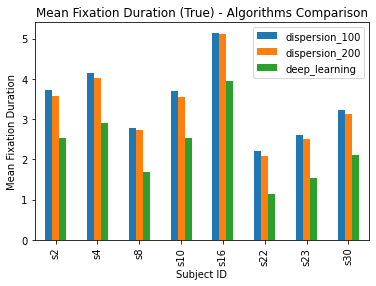

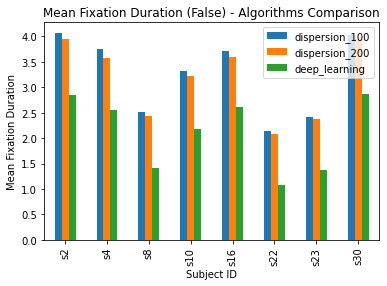

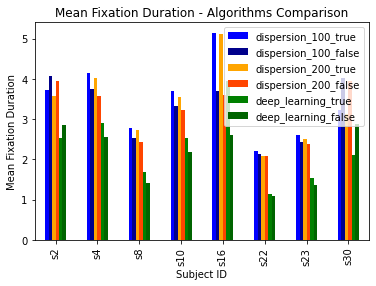

In [8]:
# Bar plots 
plotdata = pandas.DataFrame({
    "dispersion_100":dtf.MFD_true.values,
    "dispersion_200":dtf_200.MFD_true.values,
    "deep_learning":dtf_dl.MFD_true.values
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.title("Mean Fixation Duration (True) - Algorithms Comparison")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration")

# 
plotdata = pandas.DataFrame({
    "dispersion_100":dtf.MFD_false.values,
    "dispersion_200":dtf_200.MFD_false.values,
    "deep_learning":dtf_dl.MFD_false.values
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.title("Mean Fixation Duration (False) - Algorithms Comparison")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration")


# 
plotdata = pandas.DataFrame({
    "dispersion_100_true":dtf.MFD_true.values,
    "dispersion_100_false":dtf.MFD_false.values,
    "dispersion_200_true":dtf_200.MFD_true.values,
    "dispersion_200_false":dtf_200.MFD_false.values,
    "deep_learning_true":dtf_dl.MFD_true.values,
    "deep_learning_false":dtf_dl.MFD_false.values
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar", color={"dispersion_100_true": "blue", "dispersion_100_false": "darkblue", "dispersion_200_true":"orange", 
"dispersion_200_false": "orangered", "deep_learning_true": "green" ,"deep_learning_false": "darkgreen"})
plt.title("Mean Fixation Duration - Algorithms Comparison")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration")

# Task 4 - Visualization for dispersion threshold algorithm (duration threshold = 100 [ms])

In [9]:
#Xorg = dtf.values[::50,:-1].astype(float) # the provided dataset has already been reduced
Xorg = dtf.values
X = Xorg

Furthermore, we consider a subsets of 13 variables.

In [10]:
cnames = dtf.columns[:-1]
var_map = dict([(vn, vi) for (vi, vn) in enumerate(cnames)])
vnames6v = ['subject_id', 'MFD_true', 'MFD_SD_true', 'MFD_false', 'MFD_SD_false', 'MSA_true', 'MSA_SD_true', 'MSA_false',
 'MSA_SD_false', 'MFD_overall', 'MFD_overall_SD', 'MSA_overall', 'MSA_overall_SD']

For visualizing the data, we will make scatter plots for pairs of variables. With just six variables, that's already 15 unordered pairs, too many to plot them all, so we select 9 pairs.

In [11]:
vps = dict([(pname, (vnames6v.index(vA), vnames6v.index(vB)))
                for (pname, vA, vB) in 
                [("MFD_true", 'MFD_SD_true', 'MSA_true'), 
                 ("MFD_false", 'MFD_SD_false', 'MSA_false')]])


vpairs6v = get_all_pairs(4)
vpairs6v.extend([(vnames6v.index(vA), vnames6v.index(vB)) for (vA, vB) in 
                [('MFD_true', 'MSA_true'), ('MFD_false', 'MSA_false'), ('MFD_SD_true', 'MSA_SD_true')]])
vpairs6v

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (1, 5), (3, 7), (2, 6)]

We extract the desired subset of variables from the dataset.

We make a function to plot a dataset by making scatter plots of the pairs of variables, and use it to plot our experiment subset.

If cluster labels are provided, the function shows the assignment of data points to clusters by depicting them in colors. This will be useful later on.

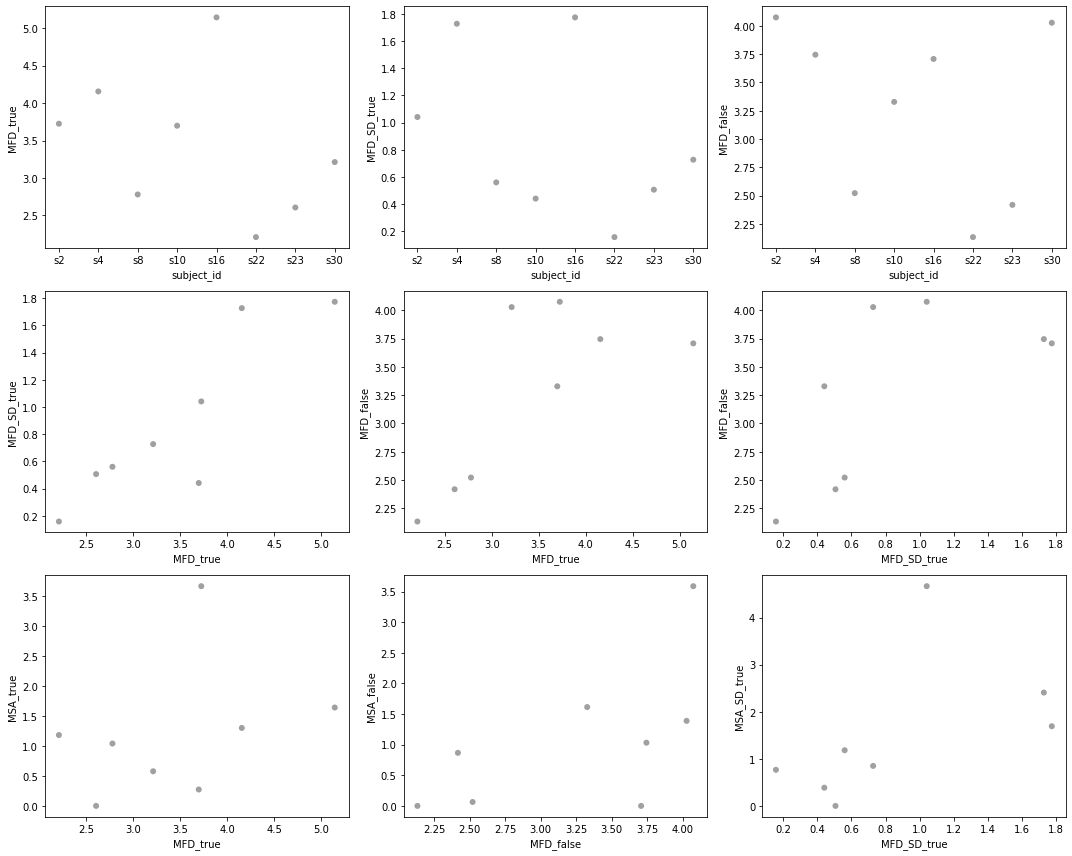

In [12]:
clust_colors_def = numpy.array(["#1965B0", "#4EB265", "#F7F056", "#DC050C", "#7BAFDE", 
                                "#CAE0AB", "#882E72", "#EE8026", "#72190E", 
                                "#888888"])

def plot_data_vpair(ax, data, vpair, vnames, clabels=None, ccenters=None, map_clabels=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    ax.set_xlabel(vnames[vpair[0]])
    ax.set_ylabel(vnames[vpair[1]])
    if clabels is not None:
        ax.scatter(data[:,vpair[0]], data[:,vpair[1]], c=clust_colors[clabels], edgecolors="none", alpha=0.8)
    else:
        ax.scatter(data[:,vpair[0]], data[:,vpair[1]], c=clust_colors[-1], edgecolors="none", alpha=0.8)
    if ccenters is not None:
        ax.scatter(ccenters[:,vpair[0]], ccenters[:,vpair[1]], s=100, c=clust_colors[map_clabels[:-1]], marker="+")
    
def plot_data(data, vnames, vpairs, clabels=None, ccenters=None, map_clabels=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    natt_cols = 3
    natt_rows = int(numpy.ceil(len(vpairs)/natt_cols))
    figsize=(15, 4*natt_rows)

    fig, axg = plt.subplots(natt_rows, natt_cols, figsize=figsize)
    axes = axg.flatten()
    for i, (xi, yi) in enumerate(vpairs):
        plot_data_vpair(axes[i], data, (xi, yi), vnames, clabels, ccenters, map_clabels, clust_colors)
        
    plt.tight_layout()
    
plot_data(X, vnames6v, vpairs6v)

Text(0, 0.5, 'Mean Saccade Amplitude')

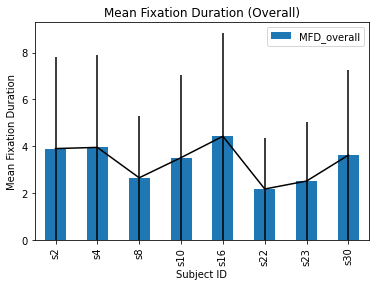

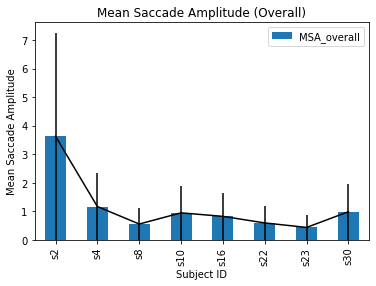

In [13]:
#MFD_overall', 'MFD_overall_SD', 'MSA_overall', 'MSA_overall_SD
plotdata = pandas.DataFrame({
    "MFD_overall":dtf.MFD_overall.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.errorbar(plotdata.index, dtf.MFD_overall.values, yerr=dtf.MFD_overall.values, color="black")
plt.title("Mean Fixation Duration (Overall)")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration")

#
plotdata = pandas.DataFrame({
    "MSA_overall":dtf.MSA_overall.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.errorbar(plotdata.index, dtf.MSA_overall.values, yerr=dtf.MSA_overall.values, color="black")
plt.title("Mean Saccade Amplitude (Overall)")
plt.xlabel("Subject ID")
plt.ylabel("Mean Saccade Amplitude")

Text(0, 0.5, 'Mean Saccade Amplitudes [ms]')

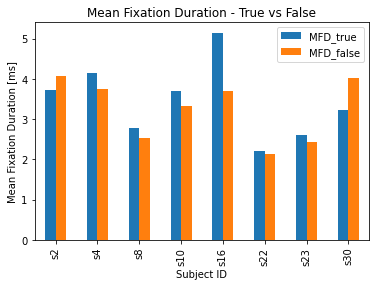

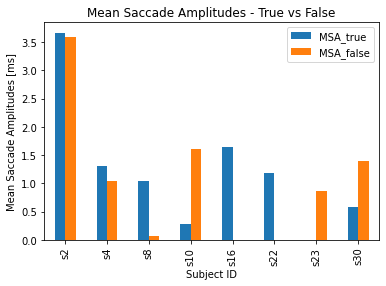

In [14]:
# Bar plots 
plotdata = pandas.DataFrame({
    "MFD_true":dtf.MFD_true.values,
    "MFD_false":dtf.MFD_false.values
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.title("Mean Fixation Duration - True vs False")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration [ms]")

#
plotdata = pandas.DataFrame({
    "MSA_true":dtf.MSA_true.values,
    "MSA_false":dtf.MSA_false.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.title("Mean Saccade Amplitudes - True vs False")
plt.xlabel("Subject ID")
plt.ylabel("Mean Saccade Amplitudes [ms]")


Text(0, 0.5, 'Mean Fixation Duration')

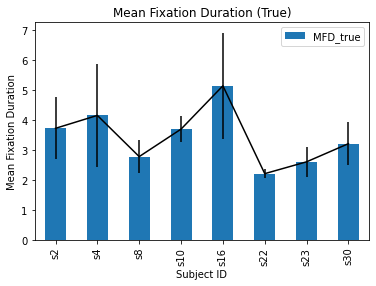

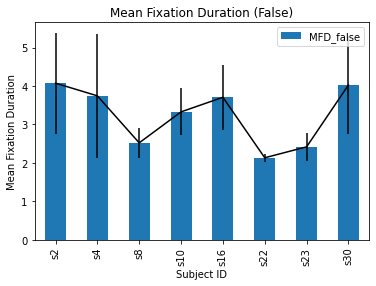

In [15]:
plotdata = pandas.DataFrame({
    "MFD_true":dtf.MFD_true.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.errorbar(plotdata.index, dtf.MFD_true.values, yerr=dtf.MFD_SD_true.values, color="black")
plt.title("Mean Fixation Duration (True)")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration")

plotdata = pandas.DataFrame({
    "MFD_false":dtf.MFD_false.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.errorbar(plotdata.index, dtf.MFD_false.values, yerr=dtf.MFD_SD_false.values, color="black")
plt.title("Mean Fixation Duration (False)")
plt.xlabel("Subject ID")
plt.ylabel("Mean Fixation Duration")

Text(0, 0.5, 'Mean Saccade Amplitudes')

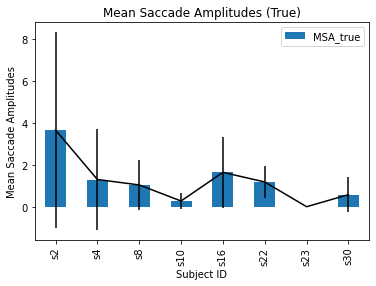

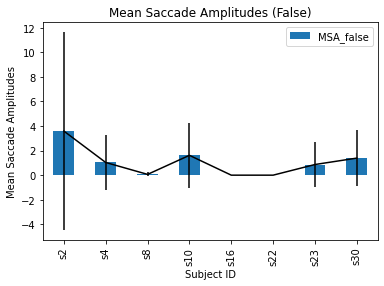

In [16]:
plotdata = pandas.DataFrame({
    "MSA_true":dtf.MSA_true.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.errorbar(plotdata.index, dtf.MSA_true.values, yerr=dtf.MSA_SD_true.values, color="black")
plt.title("Mean Saccade Amplitudes (True)")
plt.xlabel("Subject ID")
plt.ylabel("Mean Saccade Amplitudes")

plotdata = pandas.DataFrame({
    "MSA_false":dtf.MSA_false.values,
    }, 
    index = dtf.subject_id
)
plotdata.plot(kind="bar")
plt.errorbar(plotdata.index, dtf.MSA_false.values, yerr=dtf.MSA_SD_false.values, color="black")
plt.title("Mean Saccade Amplitudes (False)")
plt.xlabel("Subject ID")
plt.ylabel("Mean Saccade Amplitudes")

Acknowledgments: 
this code borrowed a code piece from "Data Analysis" Course, UEF, python notebook, Clustring lesson. 